## Test basic

Using the DGMCA code with different batch sizes and comparing its performance with the original GMCA.

- The data used for the simulation is generated following a Generalized Gaussian model of parameter *rho*. 
- Results are stored in *data_path*
- Plots are saved in *plots_path*

In [17]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from src.utils2 import divisorGenerator
from src.utils2 import Make_Experiment_GG
from src.misc_bgmca2 import *
from src.DGMCA import DGMCA as dgmca
from src.GMCA import GMCA as gmca
import copy as cp
from tqdm import tqdm
import time

### Variable definitions

In [4]:
data_path = 'data/'
plots_path = 'plots/'

totalSize = 4000 # Number of samples for each observation/source

# For the batch sizes: Use all the divisors of totalSize bigger than minSizeBlock
# Or you can define the list manually by changing the array: divisors
minSizeBlock = 500
divisors = list(divisorGenerator(totalSize))
divisors = np.array(divisors)
divisors = divisors[divisors>=minSizeBlock]

# Define your own list of batch sizes
divisors = np.array([200, 400, 600])# 200, 250 ,400, 500, 1000, 2500])

n_s = 5 # Number of sources
n_obs = 20 # Number of observations
rho = 0.5 # Generalized Gaussian generation parameter
alpha_init = 2. # Alpha parameter for the thresholding strategy

numIts = 4

CA_DGMCA = np.zeros([2,len(divisors),numIts])
CA_GMCA = np.zeros([2,numIts])
time_GMCA = np.zeros([numIts])
time_DGMCA = np.zeros([len(divisors),numIts])


# Recapitulative of the chosen parameters

print('*******************************************')
print('totalSize: ' + str(totalSize))
print('divisors: ' + str(divisors))
print('numIts: ' + str(numIts))
print('rho: ' + str(rho))
print('alpha_init: ' + str(alpha_init))
print('n_s: ' + str(n_s))
print('n_obs: ' + str(n_obs))
print('*******************************************')

# Define the saving name for the results
title_str = "test_basic_" + "_totalSize_" + str(totalSize) + "_numDivisors_" + str(len(divisors))+ "_n_obs_" + str(n_obs) \
    + "_n_s_" + str(n_s) + "_numIts_" + str(numIts)

print("Test saving name:")
print(title_str)
print('*******************************************')

*******************************************
totalSize: 4000
divisors: [200 400 600]
numIts: 4
rho: 0.5
alpha_init: 2.0
n_s: 5
n_obs: 20
*******************************************
Test saving name:
test_basic__totalSize_4000_numDivisors_3_n_obs_20_n_s_5_numIts_4
*******************************************


### Main loop

Depending on the chosen parameters it may take some time.

- First loop repeating experiments.
- Second loop on the batch sizes

In [5]:
for it_n in tqdm(range(numIts)):

    X,X0,A0,S0,N = Make_Experiment_GG(n_s=n_s,n_obs=n_obs,t_samp=totalSize,noise_level=60.0,\
                                      dynamic=0,CondNumber=1,alpha=rho)
    time1 = time.time()
    Results_sB_totSC = gmca(cp.deepcopy(X),n=n_s,maxts = 7,mints=3,nmax=100,L0=1,UseP=1,verb=0,Init=0,\
                Aposit=False,BlockSize= None,NoiseStd=[],IndNoise=[],Kmax=1.,AInit=None,tol=1e-6,threshOpt=1\
                ,SCOpt=1)
    time_GMCA[it_n] = time.time() - time1
    A_sB_totSC = Results_sB_totSC['mixmat']
    S_sB_totSC = Results_sB_totSC['sources']
    crit_sB_totSC = EvalCriterion_eval(A0,S0,A_sB_totSC,S_sB_totSC) 
    CA_GMCA[0,it_n] = crit_sB_totSC['ca_mean']
    CA_GMCA[1,it_n] = crit_sB_totSC['ca_med']


    for it1 in range(len(divisors)):

        numBlock = totalSize/divisors[it1]
        sizeBlock = divisors[it1]

        time1 = time.time()
        Results_sB0 = dgmca(cp.deepcopy(X),n=n_s,mints=3,nmax=100,L0=1,verb=0,Init=0,\
                            BlockSize= None,Kmax=1.,AInit=None,tol=1e-6,subBlockSize=sizeBlock,\
                            SCOpt=1,alphaEstOpt=1,alpha_exp=alpha_init)
        time_DGMCA[it1,it_n] = time.time() - time1
        A_sB0 = Results_sB0['mixmat']
        S_sB0 = Results_sB0['sources']
        crit_sB0 = EvalCriterion_eval(A0,S0,A_sB0,S_sB0) 
        CA_DGMCA[0,it1,it_n] = crit_sB0['ca_mean']
        CA_DGMCA[1,it1,it_n] = crit_sB0['ca_med']


 25%|██▌       | 1/4 [00:17<00:51, 17.24s/it]

WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMUTATIONS
WARNING, PSEUDO INVERSE TO CORRECT PERMU

100%|██████████| 4/4 [01:11<00:00, 17.62s/it]


### Preparing the results

In [6]:
# Some calculations to print afterwards
time_GMCA_mean = np.mean(time_GMCA,axis=0)
time_GMCA_total = np.sum(time_GMCA, axis=0)

time_DGMCA_mean = np.mean(time_DGMCA,axis=1)
time_DGMCA_mean = np.mean(time_DGMCA_mean)
time_DGMCA_total = np.sum(time_DGMCA, axis=1)
time_DGMCA_total = np.sum(time_DGMCA_total)

CA_GMCA_mean = np.mean(CA_GMCA,axis=1)
CA_DGMCA_mean = np.mean(CA_DGMCA,axis=2)
CA_GMCA_med = np.median(CA_GMCA,axis=1)
CA_DGMCA_med = np.median(CA_DGMCA,axis=2)

dB_CA_GMCA_mean = -10*np.log10(CA_GMCA_mean)
dB_CA_DGMCA_mean = -10*np.log10(CA_DGMCA_mean)
dB_CA_GMCA_med = -10*np.log10(CA_GMCA_med)
dB_CA_DGMCA_med = -10*np.log10(CA_DGMCA_med)

### Printing results

In [8]:
# Printing the results nicely
print(' ')
print('******************* Results ************************')
print('GMCA [CA(dB)]            / DGMCA [CA(dB)]')
print('GMCA mean time:  %f  / DGMCA mean time:  %f'%(time_GMCA_mean,time_DGMCA_mean))
print('GMCA total time: %f  / DGMCA total time: %f'%(time_GMCA_total,time_DGMCA_total))
print(' ')
print('**************** MEAN of experiments ***************************')
print('Total size = %d, CA_GMCA(med) = %f,  CA_GMCA(mean) = %f ;'%(totalSize,dB_CA_GMCA_mean[1],dB_CA_GMCA_mean[0]))
print('*******************************************')
for it in range(len(divisors)):
    print('Batch size = %d, CA_DGMCA(med) = %f,  CA_DGMCA(mean) = %f ;'%(divisors[it],dB_CA_DGMCA_mean[1,it],dB_CA_DGMCA_mean[0,it]))
print('*******************************************')
print(' ')
print('**************** MEDIAN of experiments ***************************')
print('Total size = %d, CA_GMCA(med) = %f,  CA_GMCA(mean) = %f ;'%(totalSize,dB_CA_GMCA_med[1],dB_CA_GMCA_med[0]))
print('*******************************************')
for it in range(len(divisors)):
    print('Batch size = %d, CA_DGMCA(med) = %f,  CA_DGMCA(mean) = %f ;'%(divisors[it],dB_CA_DGMCA_med[1,it],dB_CA_DGMCA_med[0,it]))
print('*******************************************')
print(' ')

 
******************* Results ************************
GMCA [CA(dB)]            / DGMCA [CA(dB)]
GMCA mean time:  0.522650  / DGMCA mean time:  5.708152
GMCA total time: 2.090599  / DGMCA total time: 68.497824
 
**************** MEAN of experiments ***************************
Total size = 4000, CA_GMCA(med) = 23.115809,  CA_GMCA(mean) = 21.130262 ;
*******************************************
Batch size = 200, CA_DGMCA(med) = 23.827946,  CA_DGMCA(mean) = 21.234809 ;
Batch size = 400, CA_DGMCA(med) = 23.411334,  CA_DGMCA(mean) = 21.322029 ;
Batch size = 600, CA_DGMCA(med) = 23.551087,  CA_DGMCA(mean) = 21.202718 ;
*******************************************
 
**************** MEDIAN of experiments ***************************
Total size = 4000, CA_GMCA(med) = 23.051558,  CA_GMCA(mean) = 20.742791 ;
*******************************************
Batch size = 200, CA_DGMCA(med) = 23.825650,  CA_DGMCA(mean) = 20.954641 ;
Batch size = 400, CA_DGMCA(med) = 24.249839,  CA_DGMCA(mean) = 20.996658 ;

### Saving variables

In [9]:
# Save variables
title_CA_DGMCA = data_path + 'CA_DGMCA' + title_str  
np.save(title_CA_DGMCA,CA_DGMCA)
title_CA_GMCA = data_path + 'CA_GMCA' + title_str  
np.save(title_CA_GMCA,CA_GMCA)

## Plot results nicely

Even though the results are already available they will be imported from the data folder.

In [19]:
# Import names
ext = '.npy'

imp_CA_GMCA = np.load(title_CA_GMCA + ext)
imp_CA_DGMCA = np.load(title_CA_DGMCA + ext)

# Mean over the experiments
imp_CA_GMCA = np.mean(imp_CA_GMCA,axis=1) # Over the batch sizes
imp_CA_DGMCA = np.mean(imp_CA_DGMCA,axis=2) # Over the iterations

# To dB
log_imp_CA_GMCA = -10*np.log10(imp_CA_GMCA)
log_imp_CA_DGMCA = -10*np.log10(imp_CA_DGMCA)

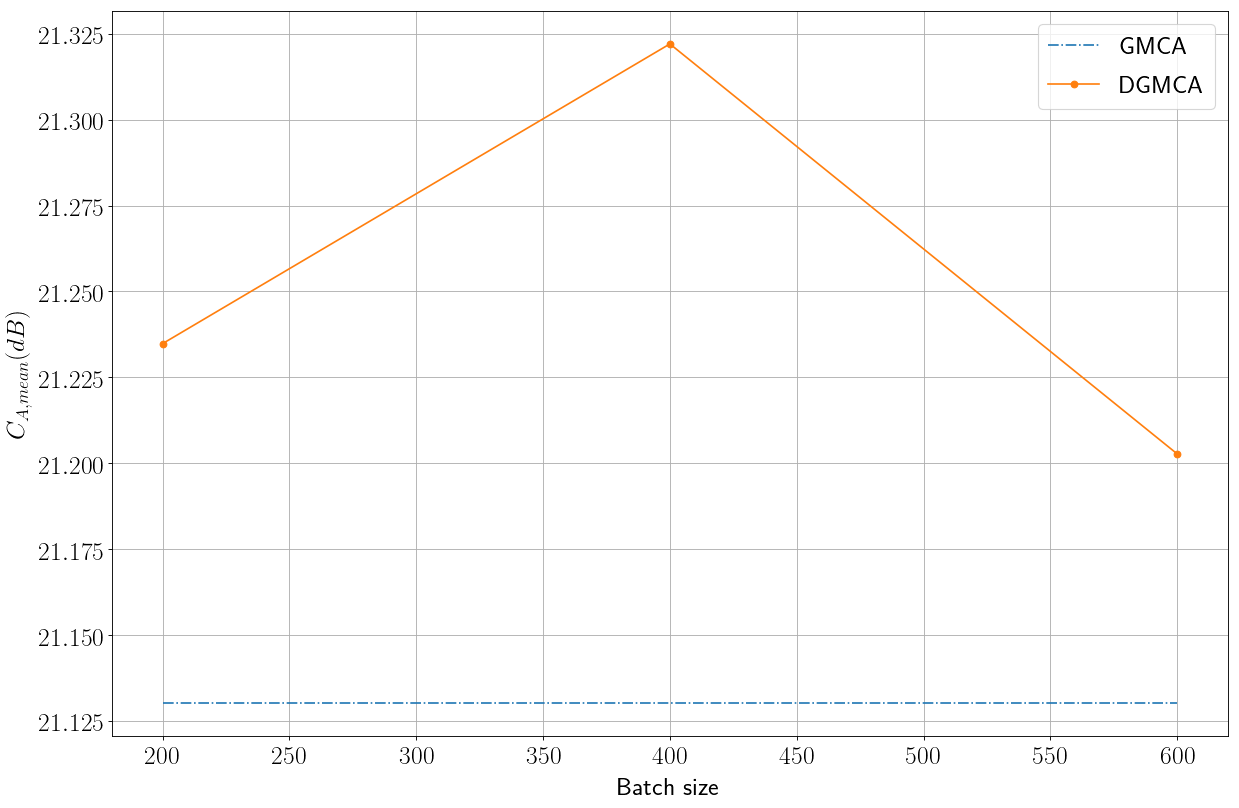

In [24]:
# Use the mean or the median over the CA 
type_ca = 0 # 0 = CA_mean // 1 = CA_median

matplotlib.rcParams.update({'font.size': 23})
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

plt.plot(divisors, log_imp_CA_GMCA[type_ca]*np.ones(len(divisors)), '-.', label=r'GMCA')
plt.plot(divisors, log_imp_CA_DGMCA[type_ca,:], '-o', label=r'DGMCA')

plt.xlabel('Batch size')
if type_ca == 0:
    plt.ylabel(r'$C_{A,mean}(dB)$')
elif type_ca == 1:
    plt.ylabel(r'$C_{A,med}(dB)$')
plt.grid()
plt.legend()
plt.show()

title_str_pdf = plots_path + title_str + ".pdf"
fig.savefig(title_str_pdf, bbox_inches='tight')